In [1]:
import cv2
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


%matplotlib inline

Using TensorFlow backend.


In [2]:
SIMULATOR_HOME = "/Users/ddigges/simulator/data/"
DRIVING_LOG_FILE = "driving_log.csv"
DRIVING_LOG_FILE_PATH = os.path.join(SIMULATOR_HOME, DRIVING_LOG_FILE)

IMG = "IMG"
IMAGE_PATH = os.path.join(os.path.join(SIMULATOR_HOME, IMG))

n = len(glob.glob(os.path.join(IMAGE_PATH, "*")))
batch_size = 128
samples_per_epoch = int(n/batch_size)
nb_epoch = 10
steering_offset = 0.08

In [3]:
driving_log = pd.read_csv(DRIVING_LOG_FILE_PATH)

In [4]:
driving_log.columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

In [5]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [6]:
image = cv2.cvtColor(plt.imread(os.path.join(SIMULATOR_HOME, driving_log[:1]['center'][0])), cv2.COLOR_BGR2YUV)

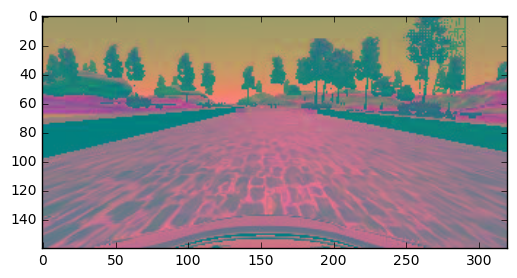

In [7]:
plt.imshow(image)

In [8]:
rows_to_crop_top = int(image.shape[0] * 0.3)
rows_to_crop_bottom = int(image.shape[0] * 0.1)

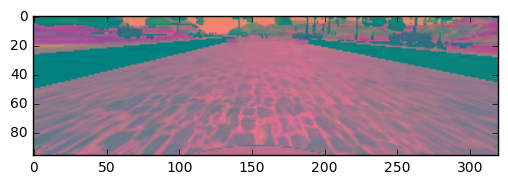

In [9]:
plt.imshow(image[rows_to_crop_top:image.shape[0] - rows_to_crop_bottom, :, :])

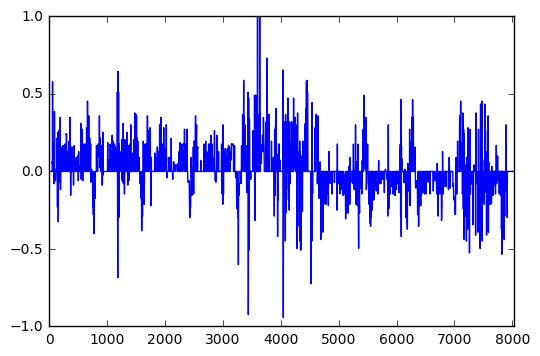

In [10]:
driving_log.steering.plot.line();

In [11]:
def read_image(file_name):
    return plt.imread(file_name)

In [12]:
val = driving_log[:1]['center']

In [13]:
image = read_image(os.path.join(SIMULATOR_HOME, val.values[0]))

In [14]:
# IMAGE: 160 x 320 with 3 color channels
image.shape

(160, 320, 3)

In [15]:
def pre_process(image):
    """
        image: input image
        
        - convert to grayscale
        - resize image to half it's original size
    """
    image = np.mean(image, axis=2)
    data_min = np.min(image)
    data_max = np.max(image)
    b = 0.5
    a = -0.5
    
    image = ((b-a) * (image - data_min)/(data_max - data_min)) + a
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    rows_to_crop = int(image.shape[0] * 0.3)
    rows_to_crop_bottom = int(image.shape[0] * 0.1)
    image = image[rows_to_crop_top:image.shape[0] - rows_to_crop_bottom, :]
    return cv2.resize(image, (0,0), fx=0.5, fy=0.5) 

def flatten(image):
    return image.reshape((image.shape[0], image.shape[1], 1))

In [16]:
for i, row in driving_log[:3].iterrows():
    print(row['center'], row['steering'])

IMG/center_2016_12_01_13_30_48_287.jpg 0.0
IMG/center_2016_12_01_13_30_48_404.jpg 0.0
IMG/center_2016_12_01_13_31_12_937.jpg 0.0


In [17]:
# shuffle
driving_log = driving_log.sample(frac=1).reset_index(drop=True)

In [18]:
driving_log.shape

(8036, 7)

In [19]:
def data_generator(df, batch_size=128):
    n_rows = df.shape[0]
    while True:
        # Shuffle the data frame rpws after every complete cycle through the data
        df = df.sample(frac=1).reset_index(drop=True)
        
        for index in range(0, n_rows, batch_size):
            df_batch = df[index: index + batch_size]

            # Ignoring the last batch which is smaller than the requested batch size
            if(df_batch.shape[0] == batch_size):
                
                for image_type in ["center"]: #, "left", "right"]:
                    X_batch = np.array([flatten(pre_process(mpimg.imread(os.path.join(SIMULATOR_HOME, row[image_type].strip())))) for i, row in df_batch.iterrows()])
                    if(image_type == "center"):
                        y_batch = np.array([row['steering'] for i, row in df_batch.iterrows()])
#                     elif(image_type == "left"):
#                         y_batch = np.array([row['steering'] + steering_offset  for i, row in df_batch.iterrows()])
#                     elif(image_type == "right"):
#                         y_batch = np.array([row['steering'] - steering_offset  for i, row in df_batch.iterrows()])
                    yield X_batch, y_batch


In [20]:
gen = data_generator(driving_log)

In [21]:
X_batch, y_batch = next(gen)

In [22]:
X_batch.shape

(128, 48, 160, 1)

In [23]:
y_batch.shape

(128,)

(array([  6.,   2.,   5.,   6.,  12.,  74.,   8.,  10.,   3.,   2.]),
 array([-0.4395315 , -0.36069677, -0.28186204, -0.20302731, -0.12419258,
        -0.04535785,  0.03347688,  0.11231161,  0.19114634,  0.26998107,
         0.3488158 ]),
 <a list of 10 Patch objects>)

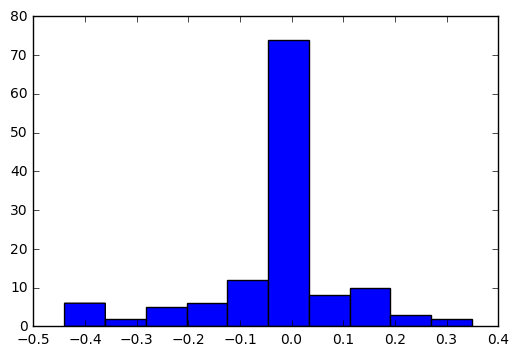

In [24]:
plt.hist(y_batch)

In [25]:
gen = data_generator(driving_log)

x,y = next(gen)
x.shape

gen = data_generator(driving_log)
print(x.shape[1], x.shape[2], 1)

48 160 1


In [26]:
model = Sequential()

model.add(Convolution2D(24, 5, 5, subsample=(4, 4), border_mode="same", input_shape=(x.shape[1], x.shape[2], 1)))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.4))
model.add(ELU())
model.add(Dense(100))
model.add(Dropout(.4))
model.add(ELU())
model.add(Dense(50))
model.add(Dropout(.4))
model.add(ELU())
model.add(Dense(1))

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")


In [27]:
model.fit_generator(gen, samples_per_epoch*batch_size, nb_epoch=5)

Epoch 1/5
24064/24064 [==============================] - 187s - loss: 0.0164   
Epoch 2/5
24064/24064 [==============================] - 203s - loss: 0.0141   
Epoch 3/5
24064/24064 [==============================] - 192s - loss: 0.0126   
Epoch 4/5
24064/24064 [==============================] - 213s - loss: 0.0125   
Epoch 5/5
24064/24064 [==============================] - 221s - loss: 0.0121   


In [28]:
model.save_weights("model.h5")

In [29]:
file = open("model.json", "w")
file.write(model.to_json())
file.close()